In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-driver-drowsiness-dataset/dataset (2).mat


In [2]:
import torch
import scipy.io as sio
import numpy as np
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:

class CNNLSTM(torch.nn.Module):
    """
    CNN-LSTM model for EEG-based drowsiness detection.
    """
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.feature=32
        self.padding= torch.nn.ReplicationPad2d((31,32,0,0))
        self.conv = torch.nn.Conv2d(1,self.feature,(1,64))
        self.batch = Batchlayer(self.feature)
        self.avgpool = torch.nn.AvgPool2d((1,8))
        self.fc = torch.nn.Linear(32, 2)
        self.softmax=torch.nn.LogSoftmax(dim=1)
        self.softmax1=torch.nn.Softmax(dim=1)
        self.lstm=torch.nn.LSTM(32, 2)
        
    def forward(self, source): 
        source = self.padding(source)
        source = self.conv(source)
        source = self.batch(source)
        source = torch.nn.ELU()(source) 
        source=self.avgpool(source)        
        source =source.squeeze()
        source=source.permute(2, 0, 1)
        source = self.lstm(source)
        source=source[1][0].squeeze()
        source = self.softmax(source)
        return source 


In [4]:
def normalizelayer(data):
    eps=1e-05
    a_mean=data-torch.mean(data, [0,2,3],True).expand(int(data.size(0)), int(data.size(1)), int(data.size(2)),int(data.size(3)))
    b=torch.div(a_mean,torch.sqrt(torch.mean((a_mean)**2, [0,2,3],True)+eps).expand(int(data.size(0)), int(data.size(1)), int(data.size(2)),int(data.size(3))))
    return b

In [5]:
class Batchlayer(torch.nn.Module):
    def __init__(self, dim):
        super(Batchlayer, self).__init__()
        self.gamma=torch.nn.Parameter(torch.Tensor(1,dim,1,1))
        self.beta=torch.nn.Parameter(torch.Tensor(1,dim,1,1))
        self.gamma.data.uniform_(-0.1, 0.1)
        self.beta.data.uniform_(-0.1, 0.1)
        
    def forward(self, input):
        data=normalizelayer(input)
        gammamatrix=self.gamma.expand(int(data.size(0)), int(data.size(1)), int(data.size(2)),int(data.size(3)))
        betamatrix = self.beta.expand(int(data.size(0)), int(data.size(1)), int(data.size(2)),int(data.size(3)))
        return data*gammamatrix+betamatrix

In [6]:
def load_data():
    filename = '/kaggle/input/eeg-driver-drowsiness-dataset/dataset (2).mat'  # Update this to the correct path
    data = sio.loadmat(filename)
    xdata = np.array(data['EEGsample'])
    label = np.array(data['substate'])
    subIdx = np.array(data['subindex'])
    
    label = label.astype(int)
    subIdx = subIdx.astype(int)
    
    return xdata, label, subIdx

In [11]:
# Step 4.1: Visualize the EEG Dataset

def visualize_eeg_data(xdata, label, subIdx, subject=1, channel=28, sample_freq=128):
    """
    Visualizes EEG signals for a specific subject and channel.
    
    Parameters:
    - xdata: EEG data array
    - label: State labels (drowsy or alert)
    - subIdx: Subject indices
    - subject: Subject ID to visualize (1 to 11)
    - channel: EEG channel to visualize (e.g., 28 for Oz)
    - sample_freq: Sampling frequency (128 Hz by default)
    """
    plt.figure(figsize=(12, 6))
    
    # Extract data for the selected subject
    subject_idx = np.where(subIdx == subject)[0]
    subject_data = xdata[subject_idx][:, channel, :]
    subject_labels = label[subject_idx]

    # Plot the first few samples for visualization
    for i in range(min(5, subject_data.shape[0])):  # Plot up to 5 samples
        plt.plot(subject_data[i], label=f'Sample {i+1} - State: {subject_labels[i]}')

    plt.title(f'Subject {subject} - Channel {channel} EEG Signals')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.grid(True)
    plt.show()



In [12]:
xdata, label, subIdx = load_data()


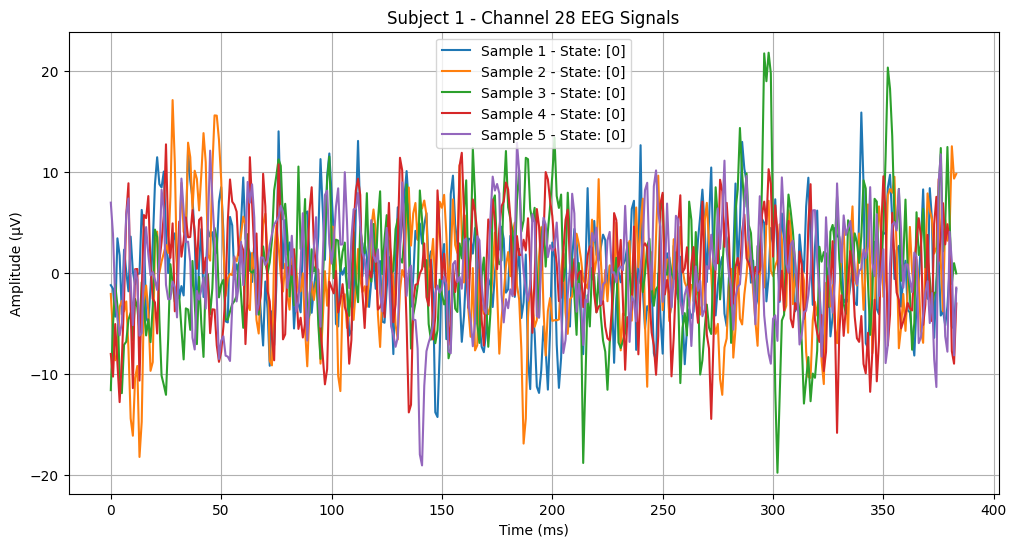

In [13]:
visualize_eeg_data(xdata, label, subIdx, subject=1, channel=28)


In [48]:
import matplotlib.pyplot as plt

# Initialize lists to store training and testing metrics
epoch_losses = []  # Store average loss per epoch for each subject
epoch_accuracies = []  # Store accuracy per epoch for each subject
test_losses = []  # Store test loss per epoch
test_accuracies = []  # Store test accuracy per epoch

# Train the model and track metrics
def train_model():
    xdata, label, subIdx = load_data()

    samplenum = label.shape[0]
    selectedchan = [28]  # Only channel Oz is used
    xdata = xdata[:, selectedchan, :]
    channelnum = len(selectedchan)

    lr = 1e-2  # Learning rate
    batch_size = 50
    n_epoch =15Number of epochs
    sf = 128  # Sampling frequency

    ydata = np.zeros(samplenum, dtype=np.longlong)
    for i in range(samplenum):
        ydata[i] = label[i]

    # Use CUDA if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for i in range(1, 12):
        trainindx = np.where(subIdx != i)[0]
        xtrain = xdata[trainindx]
        x_train = xtrain.reshape(xtrain.shape[0], 1, channelnum, 3 * sf)
        y_train = ydata[trainindx]

        testindx = np.where(subIdx == i)[0]
        xtest = xdata[testindx]
        x_test = xtest.reshape(xtest.shape[0], 1, channelnum, 3 * sf)
        y_test = ydata[testindx]

        train = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

        my_net = CNNLSTM().double().to(device)  # Send model to device
        optimizer = optim.Adam(my_net.parameters(), lr=lr)
        loss_class = torch.nn.NLLLoss().to(device)  # Loss on the same device

        subject_losses = []
        subject_accuracies = []

        for epoch in range(n_epoch):
            total_loss = 0.0
            my_net.train()

            for j, data in enumerate(train_loader, 0):
                inputs, labels = data
                input_data = inputs.to(device).double()
                class_label = labels.to(device).long()

                my_net.zero_grad()
                class_output = my_net(input_data)
                err_s_label = loss_class(class_output, class_label)
                err_s_label.backward()
                optimizer.step()

                total_loss += err_s_label.item()

            avg_loss = total_loss / len(train_loader)
            subject_losses.append(avg_loss)

            print(f"Subject {i} | Epoch [{epoch+1}/{n_epoch}] | Loss: {avg_loss:.4f}")

            # Evaluate the model on the test set
            my_net.eval()
            with torch.no_grad():
                x_test_tensor = torch.from_numpy(x_test).to(device).double()
                answer = my_net(x_test_tensor)
                probs = answer.cpu().numpy()
                preds = probs.argmax(axis=-1)

                acc = accuracy_score(y_test, preds)
                subject_accuracies.append(acc)

                # Calculate test loss
                test_loss = loss_class(answer, torch.tensor(y_test).to(device).long()).item()
                test_losses.append(test_loss)
                test_accuracies.append(acc)

            print(f"Subject {i} | Epoch [{epoch+1}/{n_epoch}] | Accuracy: {acc:.4f}")

        epoch_losses.append(subject_losses)
        epoch_accuracies.append(subject_accuracies)

    # Calculate and plot average accuracy per epoch across subjects
    avg_accuracies = np.mean(np.array(epoch_accuracies), axis=0)

    plt.figure()
    plt.plot(range(1, n_epoch + 1), avg_accuracies, marker='o')
    plt.title('Average Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Accuracy')
    plt.grid(True)
    plt.show()
    # Save the trained model
    torch.save(my_net.state_dict(), "cnn_lstm_model.pth")

/tmp/ipykernel_30/784929711.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ydata[i] = label[i]


Subject 1 | Epoch [1/30] | Loss: 0.6956
Subject 1 | Epoch [1/30] | Accuracy: 0.5851
Subject 1 | Epoch [2/30] | Loss: 0.6861
Subject 1 | Epoch [2/30] | Accuracy: 0.5851
Subject 1 | Epoch [3/30] | Loss: 0.6820
Subject 1 | Epoch [3/30] | Accuracy: 0.5957
Subject 1 | Epoch [4/30] | Loss: 0.6725
Subject 1 | Epoch [4/30] | Accuracy: 0.6702
Subject 1 | Epoch [5/30] | Loss: 0.6636
Subject 1 | Epoch [5/30] | Accuracy: 0.6862
Subject 1 | Epoch [6/30] | Loss: 0.6302
Subject 1 | Epoch [6/30] | Accuracy: 0.7553
Subject 1 | Epoch [7/30] | Loss: 0.5856
Subject 1 | Epoch [7/30] | Accuracy: 0.8191
Subject 1 | Epoch [8/30] | Loss: 0.5702
Subject 1 | Epoch [8/30] | Accuracy: 0.7979
Subject 1 | Epoch [9/30] | Loss: 0.5608
Subject 1 | Epoch [9/30] | Accuracy: 0.7713
Subject 1 | Epoch [10/30] | Loss: 0.5616
Subject 1 | Epoch [10/30] | Accuracy: 0.7819
Subject 1 | Epoch [11/30] | Loss: 0.5660
Subject 1 | Epoch [11/30] | Accuracy: 0.7872
Subject 1 | Epoch [12/30] | Loss: 0.5554
Subject 1 | Epoch [12/30] | Acc

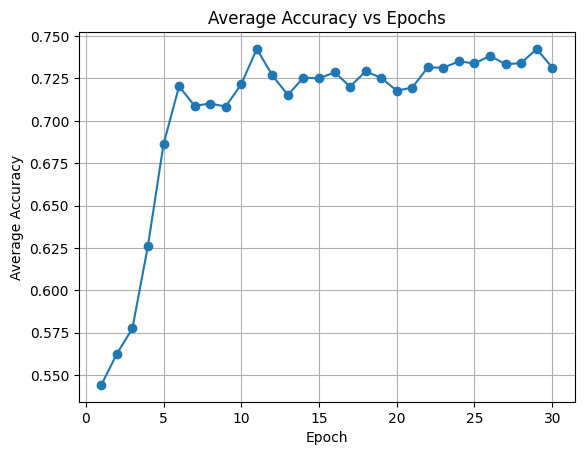

In [49]:
train_model()

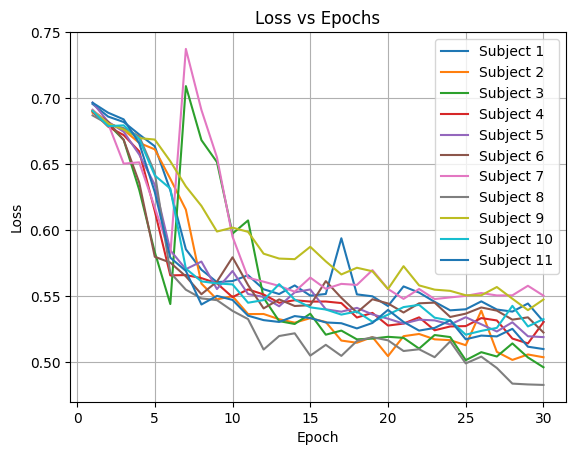

In [50]:
for i, losses in enumerate(epoch_losses):
    plt.plot(range(1, len(losses) + 1), losses, label=f'Subject {i+1}')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

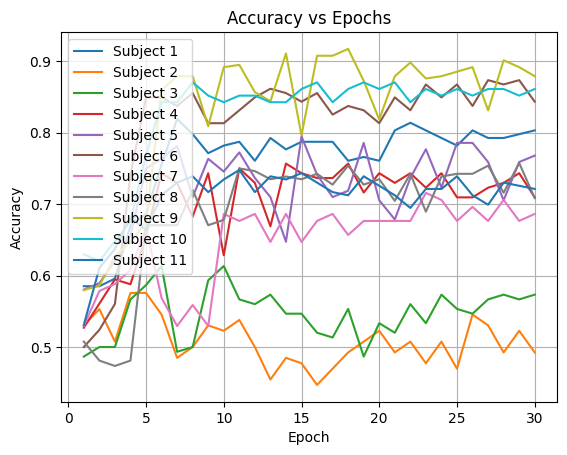

In [51]:
for i, accuracies in enumerate(epoch_accuracies):
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=f'Subject {i+1}')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


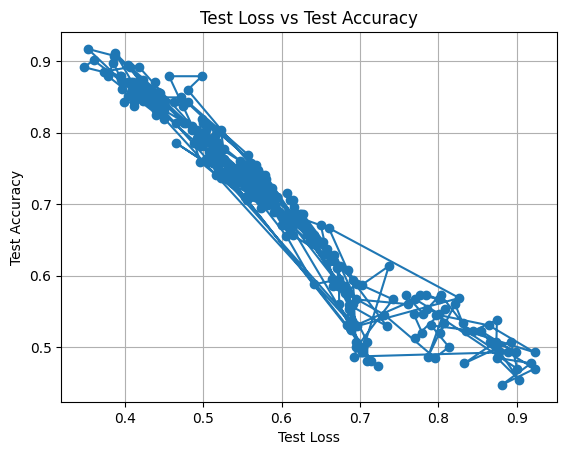

In [52]:
# Plot Test Loss vs. Test Accuracy
plt.figure()
plt.plot(test_losses, test_accuracies, marker='o')
plt.title('Test Loss vs Test Accuracy')
plt.xlabel('Test Loss')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_predictions(y_true, y_pred, subject):
    """
    Plots predictions vs. true labels and the confusion matrix.
    
    Parameters:
    - y_true: Array of true labels
    - y_pred: Array of predicted labels
    - subject: Subject ID for labeling the plots
    """
    # Plot 1: True vs. Predicted Labels
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='True Labels', marker='o', linestyle='--', color='b')
    plt.plot(y_pred, label='Predicted Labels', marker='x', linestyle='-', color='r')
    plt.title(f'Subject {subject} - True vs. Predicted Labels')
    plt.xlabel('Sample Index')
    plt.ylabel('State (0: Alert, 1: Drowsy)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Alert", "Drowsy"])
    disp.plot(cmap='Blues')
    plt.title(f'Subject {subject} - Confusion Matrix')
    plt.show()


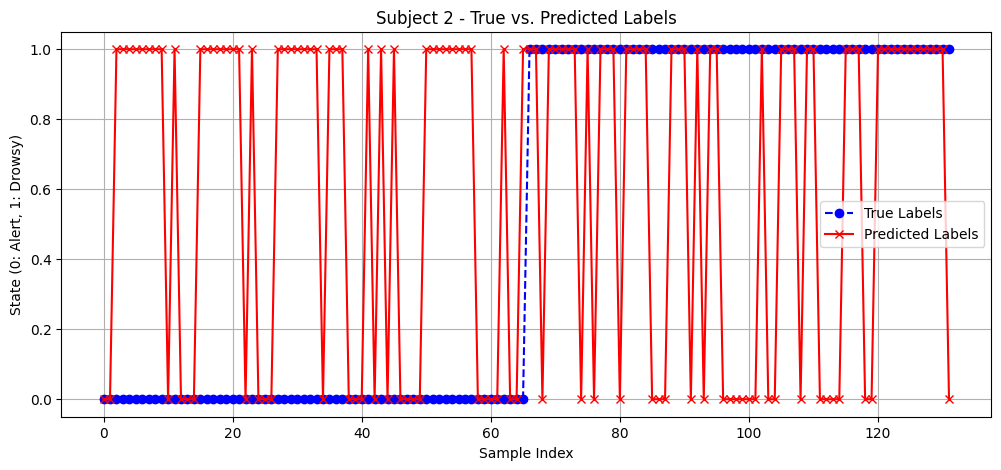

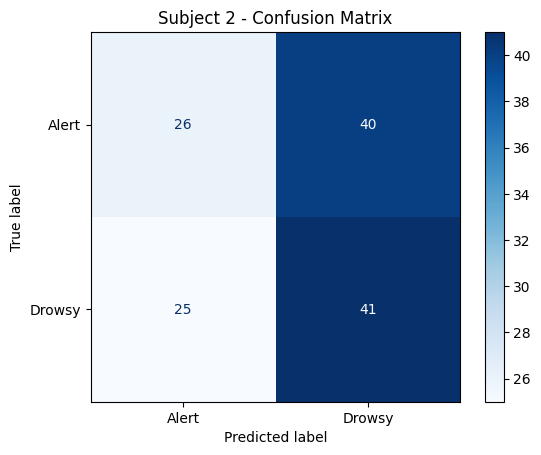

In [56]:
subject_id = 2  # Choose any subject between 1 to 11
y_true, y_pred = all_predictions[subject_id]
plot_predictions(y_true, y_pred, subject=subject_id)


In [46]:
# Load the trained model function
def load_trained_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNLSTM().double().to(device)  # Load CNN-LSTM model
    model.load_state_dict(torch.load("cnn_lstm_model.pth", weights_only=True))  # Load weights only
    return model


In [47]:
import torch
import scipy.io as sio
import numpy as np

# Load the trained model function
def load_trained_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNLSTM().double().to(device)  # Load CNN-LSTM model
    model.load_state_dict(torch.load("cnn_lstm_model.pth", weights_only=True))  # Load weights only
    model.eval()  # Set the model to evaluation mode
    return model

# Load and prepare test data
def load_test_data():
    filename = '/kaggle/input/eeg-driver-drowsiness-dataset/dataset (2).mat'  # Update this to the correct path of your test data
    data = sio.loadmat(filename)
    x_test = np.array(data['EEGsample'])  # Adjust this based on your test data structure
    return x_test

# Prepare test data for prediction
def prepare_test_data(x_test):
    selectedchan = [28]  # Only channel Oz is used
    x_test = x_test[:, selectedchan, :]  # Select the desired channel
    sf = 128  # Sampling frequency
    x_test = x_test.reshape(x_test.shape[0], 1, 1, 3 * sf)  # Reshape for CNN input
    return x_test

# Main code to run predictions
if __name__ == "__main__":
    # Load the trained model and test data
    model = load_trained_model()
    x_test = load_test_data()

    # Prepare the test data
    x_test_prepared = prepare_test_data(x_test)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.DoubleTensor(x_test_prepared).cuda()  # Move to GPU if available

    # Make predictions
    with torch.no_grad():
        output = model(x_test_tensor)  # Forward pass
        probabilities = torch.exp(output).cpu().numpy()  # Get probabilities
        predictions = np.argmax(probabilities, axis=1)  # Get predicted classes

    # Output predictions
    for i, pred in enumerate(predictions):
        print(f"Sample {i + 1}: {'Drowsy' if pred == 1 else 'Alert'} (Prediction: {pred})")


Sample 1: Alert (Prediction: 0)
Sample 2: Alert (Prediction: 0)
Sample 3: Alert (Prediction: 0)
Sample 4: Alert (Prediction: 0)
Sample 5: Alert (Prediction: 0)
Sample 6: Alert (Prediction: 0)
Sample 7: Alert (Prediction: 0)
Sample 8: Alert (Prediction: 0)
Sample 9: Alert (Prediction: 0)
Sample 10: Alert (Prediction: 0)
Sample 11: Alert (Prediction: 0)
Sample 12: Alert (Prediction: 0)
Sample 13: Alert (Prediction: 0)
Sample 14: Alert (Prediction: 0)
Sample 15: Alert (Prediction: 0)
Sample 16: Alert (Prediction: 0)
Sample 17: Drowsy (Prediction: 1)
Sample 18: Alert (Prediction: 0)
Sample 19: Drowsy (Prediction: 1)
Sample 20: Alert (Prediction: 0)
Sample 21: Alert (Prediction: 0)
Sample 22: Alert (Prediction: 0)
Sample 23: Alert (Prediction: 0)
Sample 24: Alert (Prediction: 0)
Sample 25: Alert (Prediction: 0)
Sample 26: Alert (Prediction: 0)
Sample 27: Alert (Prediction: 0)
Sample 28: Alert (Prediction: 0)
Sample 29: Alert (Prediction: 0)
Sample 30: Drowsy (Prediction: 1)
Sample 31: Alert